# "Full Metadata" Spreadsheet (working title)

See [ticket 576](https://app.zenhub.com/workspaces/dcp-ingest-product-development-5f71ca62a3cb47326bdc1b5c/issues/ebi-ait/dcp-ingest-central/576)

This is an initial attempt for enabling data consumers to explore the metadata of an HCA project with common simple tools with minimal coding such as Excel Pivot Tables.

- 1st draft - v0.1 - metadata from sequence files to donors - [see example]()
- next up - analysis files

In [166]:
spreadsheet = './data/GSE135893_HCAD15.xlsx'
version = '0.1'

Define an Entity Relationship model (entity is a worksheet)

In [163]:
from dataclasses import dataclass

@dataclass
class SequencingProtocol:
    SEQUENCING_PROTOCOL_ID_Required: str
@dataclass
class LibraryPreparationProtocol:
    LIBRARY_PREPARATION_PROTOCOL_ID: str

@dataclass
class DissociationProtocol:
    DISSOCIATION_PROTOCOL_ID:str

@dataclass
class CollectionProtocol:
    COLLECTION_PROTOCOL_ID:str

@dataclass
class DonorOrganism:
    DONOR_ORGANISM_ID:str 
        
@dataclass
class SpecimenFromOrganism:
    SPECIMEN_FROM_ORGANISM_ID:str
    COLLECTION_PROTOCOL_ID:CollectionProtocol
    INPUT_DONOR_ORGANISM_ID:DonorOrganism
        
@dataclass
class EnrichmentProtocol:
    ENRICHMENT_PROTOCOL_ID:str
            
@dataclass
class CellSuspension:
    CELL_SUSPENSION_ID: str
    ENRICHMENT_PROTOCOL_ID:EnrichmentProtocol
    INPUT_SPECIMEN_FROM_ORGANISM_ID:SpecimenFromOrganism
    DISSOCIATION_PROTOCOL_ID:DissociationProtocol
    
@dataclass
class SequenceFile:
    SEQUENCING_PROTOCOL_ID_Required: SequencingProtocol
    LIBRARY_PREPARATION_PROTOCOL_ID_Required: LibraryPreparationProtocol
    INPUT_CELL_SUSPENSION_ID_Required: CellSuspension

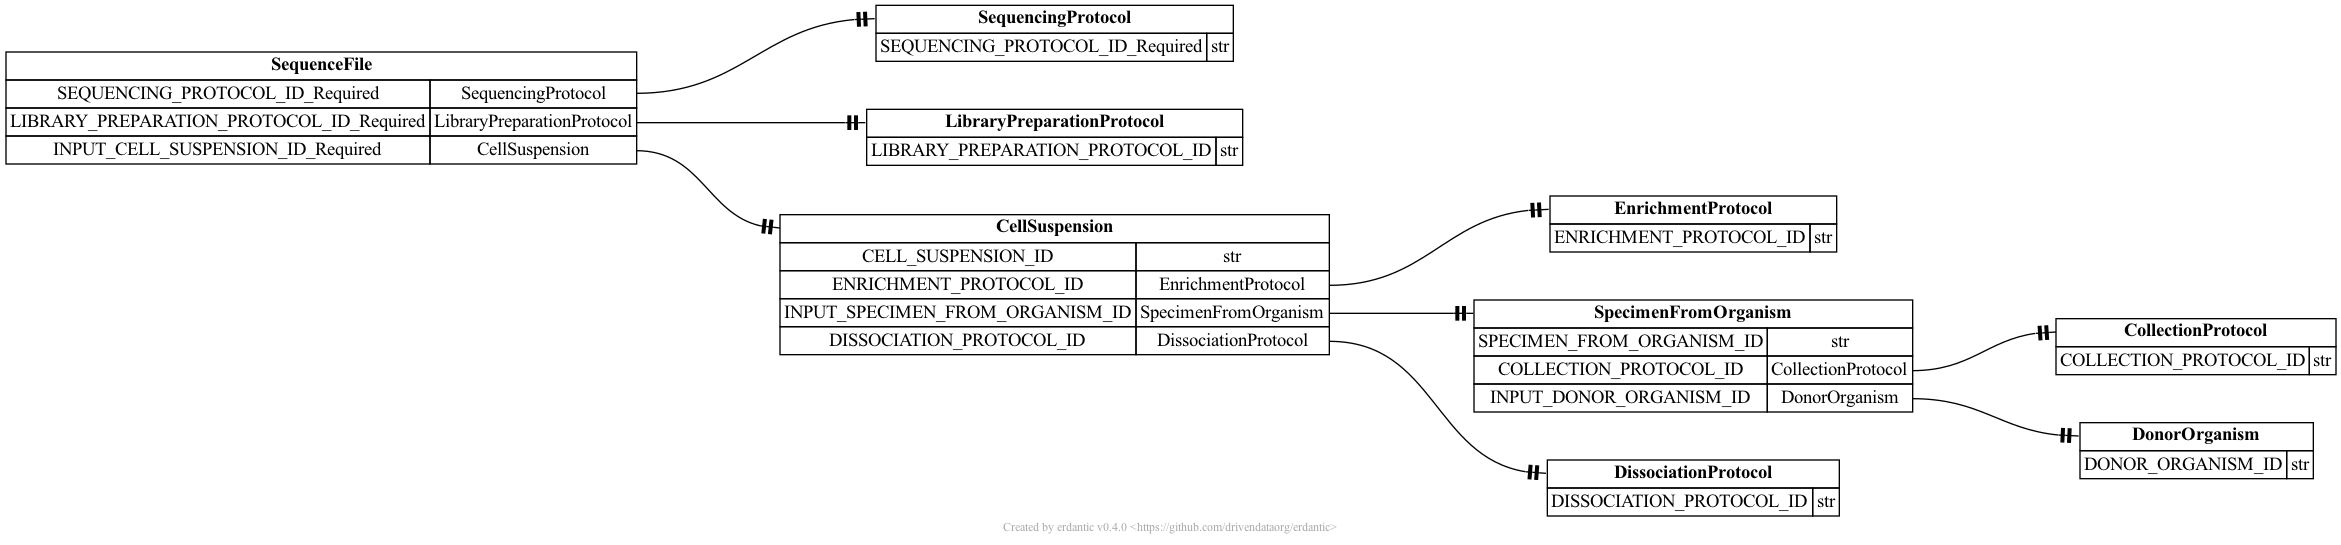

In [164]:
import erdantic as erd
diagram = erd.create(SequenceFile)
diagram

In [161]:
        
Link = namedtuple("Link", 'source target source_field target_field')
        
# TODO: links list is assumed to be topologically sorted, in the future - sort
links = [
    Link('Sequence file', 'Sequencing protocol', 'SEQUENCING PROTOCOL ID (Required)','SEQUENCING PROTOCOL ID (Required)'),
    Link('Sequence file','Library preparation protocol', 'LIBRARY PREPARATION PROTOCOL ID (Required)', 'LIBRARY PREPARATION PROTOCOL ID (Required)'),
    Link('Sequence file', 'Cell suspension', 'INPUT CELL SUSPENSION ID (Required)','CELL SUSPENSION ID (Required)'),
    Link('Cell suspension', 'Enrichment protocol','ENRICHMENT PROTOCOL ID (Required)','ENRICHMENT PROTOCOL ID (Required)'),
    Link('Cell suspension', 'Specimen from organism','INPUT SPECIMEN FROM ORGANISM ID (Required)','SPECIMEN FROM ORGANISM ID (Required)'),
    Link('Cell suspension', 'Dissociation protocol','DISSOCIATION PROTOCOL ID (Required)','DISSOCIATION PROTOCOL ID (Required)'),
    Link('Specimen from organism', 'Collection protocol', 'COLLECTION PROTOCOL ID (Required)','COLLECTION PROTOCOL ID (Required)'),
    Link('Specimen from organism', 'Donor organism','INPUT DONOR ORGANISM ID (Required)','DONOR ORGANISM ID (Required)'),
]

{('Sequence file',
  'Sequencing protocol'): Text(0.6893745678005772, 0.1730946084503383, 'SEQUENCING PROTOCOL ID (Required)\n->SEQUENCING PROTOCOL ID (Required)'),
 ('Sequence file',
  'Library preparation protocol'): Text(0.7643500820894691, -0.10243635007336697, 'LIBRARY PREPARATION PROTOCOL ID (Required)\n->LIBRARY PREPARATION PROTOCOL ID (Required)'),
 ('Sequence file',
  'Cell suspension'): Text(0.19019875779195988, -0.12697099080385432, 'INPUT CELL SUSPENSION ID (Required)\n->CELL SUSPENSION ID (Required)'),
 ('Cell suspension',
  'Enrichment protocol'): Text(-0.3919870181879139, -0.32398735743989326, 'ENRICHMENT PROTOCOL ID (Required)\n->ENRICHMENT PROTOCOL ID (Required)'),
 ('Cell suspension',
  'Specimen from organism'): Text(-0.31445484334484153, 0.027570654281993928, 'INPUT SPECIMEN FROM ORGANISM ID (Required)\n->SPECIMEN FROM ORGANISM ID (Required)'),
 ('Cell suspension',
  'Dissociation protocol'): Text(-0.17197852418553178, -0.4785035454229465, 'DISSOCIATION PROTOCOL ID 

<Figure size 432x288 with 0 Axes>

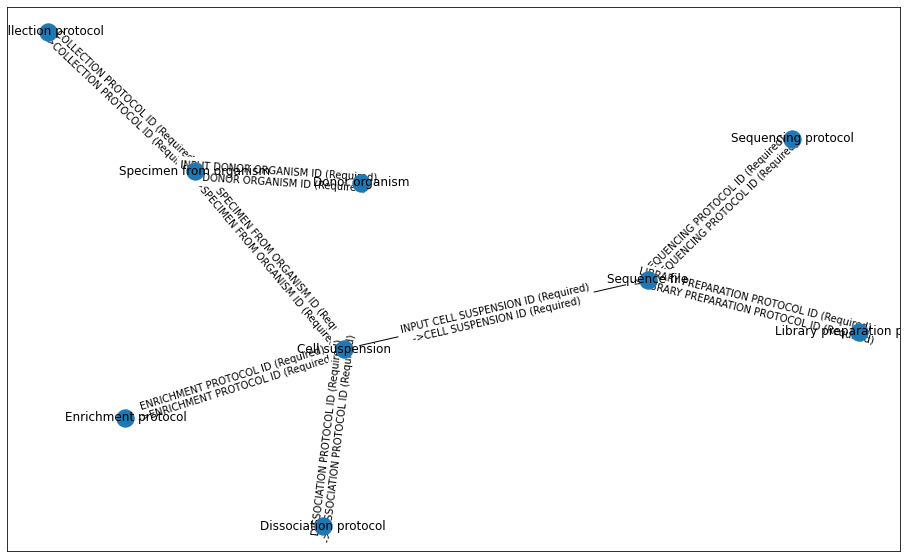

In [148]:
import networkx as nx
import matplotlib.pyplot as plt
from functools import partial
%matplotlib inline


def add_link_to_graph(graph :nx.Graph, link :Link):
    map(graph.add_node, filter(lambda node:node not in graph.nodes, [link.source, link.target] ))
    graph.add_edge(link.source, link.target, keys=f'{link.source_field}\n->{link.target_field}')

G = nx.Graph()
x =list(map(partial(add_link_to_graph, G), links))

fig = plt.figure()
plt.figure(figsize=(16, 10))

labels = nx.get_edge_attributes(G, 'keys')
pos = nx.spring_layout(G)          
nx.draw_networkx(G, pos, arrowstyle="->",)
nx.draw_networkx_edge_labels(G, pos, labels, font_size=10)


In [131]:
# TODO: skip unnecessary lines
# TODO: natural language column names vs variable names
# TODO: render graph
# TODO: analysis file linking

def join_worksheet(worksheet, link:Link, spreadsheet):
    df = pd.read_excel(spreadsheet, link.target)
    result = worksheet.merge(df, left_on=link.source_field, right_on=link.target_field)
    return result

In [132]:
import pandas as pd
from collections import namedtuple
from functools import reduce

sequence_file = pd.read_excel(spreadsheet, 'Sequence file')

flattened = reduce(partial(join_worksheet,spreadsheet=spreadsheet), 
                   links,
                   sequence_file)

In [137]:
from os.path import basename, splitext
flattened_filename = f'./examples/{splitext(basename(spreadsheet))[0]}_denormalised_v{version}.xlsx'
flattened.to_excel(flattened_filename)

In [143]:
import openpyxl
fh = openpyxl.load_workbook(flattened_filename)

obj = fh.properties   
project_info = pd.read_excel(spreadsheet, 'Project')
data_row_idx = 4
project_label = project_info['PROJECT LABEL (Required)'][data_row_idx]

fh.properties.title = f'flattened hca metadata for project {project_label}'
fh.properties.version = version
fh.properties.keywords = f'flattened,hca,metadata,{project_label}'

fh.save(flattened_filename)

In [134]:
flattened

,FILE NAME (Required),FILE FORMAT (Required),CONTENT DESCRIPTION,CONTENT DESCRIPTION ONTOLOGY ID,CONTENT DESCRIPTION ONTOLOGY LABEL ONTOLOGY ID,CHECKSUM,READ INDEX (Required),LANE INDEX,READ LENGTH,INSDC RUN ACCESSION,...,END TIME_y,LENGTH OF TIME_y,LENGTH OF TIME UNIT_y,LENGTH OF TIME UNIT ONTOLOGY ID_y,LENGTH OF TIME UNIT ONTOLOGY LABEL ONTOLOGY ID_y,PROCESS TYPE (Required)_y,PROCESS TYPE ONTOLOGY ID_y,PROCESS TYPE ONTOLOGY LABEL ONTOLOGY ID_y,DEVIATION FROM PROTOCOL_y,INSDC EXPERIMENT ACCESSION (Required)_y
0,The name of the file.,The format of the file.,General description of the contents of the file.,An ontology term identifier in the form prefix...,The preferred label for the ontology term refe...,MD5 checksum of the file.,The sequencing read this file represents.,The lane that this file was sequenced from.,"The length of a sequenced read in this file, i...",An International Nucleotide Sequence Database ...,...,Date and time the process ended.,Length of time the process took to execute in ...,A term that may be associated with a time unit...,An ontology term identifier in the form prefix...,The preferred label for the ontology term refe...,A term that may be associated with a process-r...,An ontology term identifier in the form prefix...,The preferred label for the ontology term refe...,A deviation from the protocol provided.,An International Nucleotide Sequence Database ...
1,Include the file extension in the file name. F...,Indicate the full file extension including com...,For example: DNA sequence (raw); Sequence ali...,For example: data:3497; data:0863,For example: DNA sequence (raw); Sequence ali...,For example: e09a986c2e630130b1849d4bf9a94c06,"If a sequencing experiment is single-end, ente...",For example: 1,For example: 51,Enter accession if run has been archived. Acce...,...,Enter the time in date-time format: yyyy-mm-dd...,Enter a single value or a range of values sepa...,For example: second; week,For example: UO:0000010; UO:0000034,For example: second; week,For example: enzymatic dissociation; blood draw,For example: EFO:0009128; EFO:0009121,For example: enzymatic dissociation; blood draw,For example: Skipped ACK lysis step; Used 100...,Enter accession if experiment has been archive...
2,sequence_file.file_core.file_name,sequence_file.file_core.format,sequence_file.file_core.content_description.text,sequence_file.file_core.content_description.on...,sequence_file.file_core.content_description.on...,sequence_file.file_core.checksum,sequence_file.read_index,sequence_file.lane_index,sequence_file.read_length,sequence_file.insdc_run_accessions,...,process.end_time,process.length_of_time,process.length_of_time_unit.text,process.length_of_time_unit.ontology,process.length_of_time_unit.ontology_label,process.type.text,process.type.ontology,process.type.ontology_label,process.deviation_from_protocol,process.insdc_experiment.insdc_experiment_acce...
3,IPF_VUILD48_1_LU_SCS_C1_X5SCR_F00202_HMWLCBGX7...,fastq.gz,DNA sequence,data:3494,DNA sequence,NaN,read1,1,NaN,SRR9985297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IPF_VUILD48_1_LU_SCS_C1_X5SCR_F00202_HMWLCBGX7...,fastq.gz,DNA sequence,data:3494,DNA sequence,NaN,read2,1,NaN,SRR9985297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,IPF_TILD001_1_LF_Whole_C1_X5SCR_F00431_HWYTFBB...,fastq.gz,DNA sequence,data:3494,DNA sequence,NaN,read2,6,NaN,SRR9985371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
821,IPF_TILD001_1_LF_Whole_C1_X5SCR_F00431_HWYTFBB...,fastq.gz,DNA sequence,data:3494,DNA sequence,NaN,read1,7,NaN,SRR9985372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
822,IPF_TILD001_1_LF_Whole_C1_X5SCR_F00431_HWYTFBB...,fastq.gz,DNA sequence,data:3494,DNA sequence,NaN,read2,7,NaN,SRR9985372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
823,IPF_TILD001_1_LF_Whole_C1_X5SCR_F00431_HWYTFBB...,fastq.gz,DNA sequence,data:3494,DNA sequence,NaN,read1,8,NaN,SRR9985373,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN